In [ ]:
# !pip install huggingface_hub
# !pip install torch
# !pip install --upgrade transformers

In [ ]:
from huggingface_hub import hf_hub_download
import torch

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install transformers==4.40.1 # Use this version and Python 3.10 for stable compatibility

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.1 which is incompatible.


In [ ]:
import torch
from transformers import AutoModelForCausalLM

#### Test it on my data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
# script that takes in raw signals and outputs cleaned up signals

import numpy as np
import scipy.interpolate as interp
import copy
import torch
import pandas as pd
import wfdb
import os


def read_records(data_dir):
    """
    Iterates through .dat files in data_dir, reads them using wfdb,
    and stores them in a dictionary.

    Args:
      data_dir: The directory containing the .dat files.

    Returns:
      A dictionary where keys are filenames (without extension) and
      values are wfdb.Record objects.
      Returns an empty dictionary if no .dat files are found or an error occurs.
    """
    records = {}
    for filename in os.listdir(data_dir):
        if filename.endswith(".dat"):
            record_id = filename[:-4]  # Remove the .dat extension
            try:
                record = wfdb.rdrecord(os.path.join(data_dir, record_id))
                records[record_id] = record
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    return records

labels_path = "/content/drive/MyDrive/Msc/Other Projects/RAJA/labels.csv"
input_data_dir = "/content/drive/MyDrive/Msc/Other Projects/RAJA/ctu-chb-intrapartum-cardiotocography-database-1.0.0"

all_records = read_records(input_data_dir)
labels = pd.read_csv(labels_path)

In [ ]:
import numpy as np

def trim_edges(arr):
    arr = np.array(arr)  # Convert to NumPy array for easy processing
    nonzero_indices = np.nonzero(arr)[0]  # Find indices of nonzero elements
    if len(nonzero_indices) == 0:  # If all elements are zero, return an empty list
        return []
    # return arr[nonzero_indices[0]: nonzero_indices[-1] + 1]  # Slice between first and last nonzero
    return nonzero_indices[0], nonzero_indices[-1] + 1, arr[nonzero_indices[0]: nonzero_indices[-1] + 1]  # Slice between first and last nonzero


In [ ]:
import matplotlib.pyplot as plt

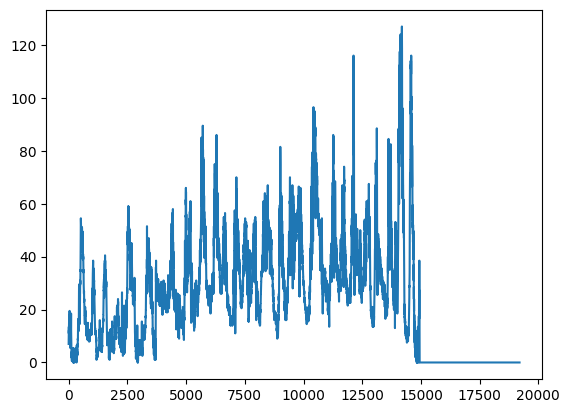

In [ ]:
plt.plot(all_records['1001'].p_signal[:,1])

In [ ]:
# fhrs = {}
# ucs = {}
# for record_name, record in all_records.items():
#     fhrs[record_name] = trim_edges(record.p_signal[:,0])
#     ucs[record_name] = trim_edges(record.p_signal[:,1])


fhrs = {}
ucs = {}
for record_name, record in all_records.items():
    left, right, fhrs[record_name] = trim_edges(record.p_signal[:,0])
    ucs[record_name] = np.array(record.p_signal[:,1])[left:right]

In [ ]:
fhrs_df = pd.DataFrame.from_dict(fhrs, orient='index') # 552 rows
ucs_df = pd.DataFrame.from_dict(ucs, orient='index')

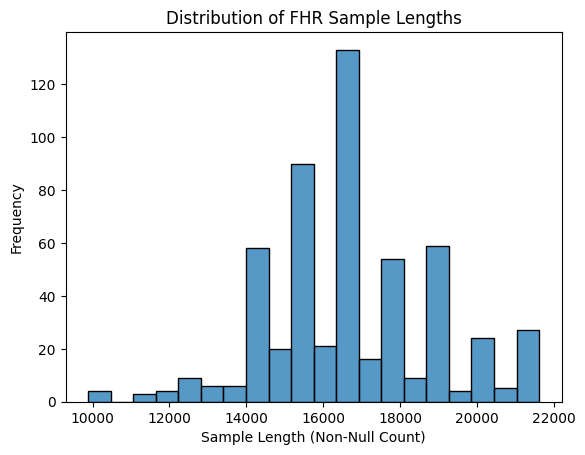

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count non-null values per row
sample_lengths = fhrs_df.notnull().sum(axis=1)

# Plot histogram
sns.histplot(sample_lengths, bins=20)  # Adjust bins as needed
plt.xlabel("Sample Length (Non-Null Count)")
plt.ylabel("Frequency")
plt.title("Distribution of FHR Sample Lengths")
plt.show()

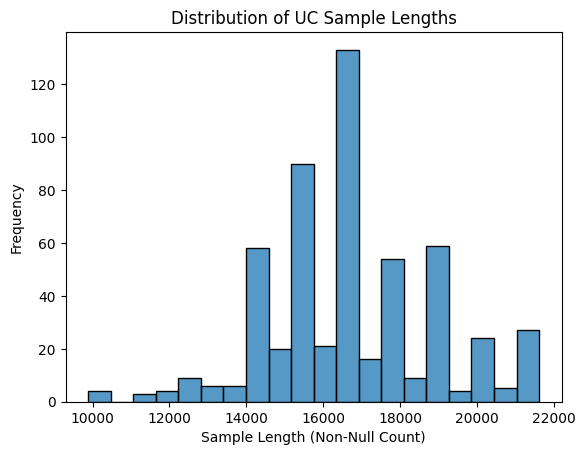

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count non-null values per row
sample_lengths = ucs_df.notnull().sum(axis=1)

# Plot histogram
sns.histplot(sample_lengths, bins=20)  # Adjust bins as needed
plt.xlabel("Sample Length (Non-Null Count)")
plt.ylabel("Frequency")
plt.title("Distribution of UC Sample Lengths")
plt.show()

In [ ]:
fhrs_df_14k = fhrs_df.dropna(thresh=14400) # 508 rows

In [ ]:
ucs_df_14k = ucs_df.loc[fhrs_df_14k.index]

In [ ]:
fhrs_df_last_hour = fhrs_df_14k.apply(lambda row: pd.Series(row.dropna().values[-14400:]), axis=1)
ucs_df_last_hour = ucs_df_14k.apply(lambda row: pd.Series(row.dropna().values[-14400:]), axis=1)

In [ ]:
import matplotlib.pyplot as plt

def plot_5x5_subplots(df,label1="Observed",start_index=15, title="",compare = None, label2=""):
      fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Create a 5x5 grid
      axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

      for i, IDX in enumerate(range(start_index, start_index+25)):
          ax = axes[i]  # Select the corresponding subplot
          ax.plot(df.iloc[IDX, :], label=label1)
          if compare is not None:
            ax.plot(compare.iloc[IDX, :], label=label2)
          ax.set_title(f"Sample {df.iloc[IDX, :].name}")

      fig.suptitle(title, fontsize=18, fontweight="bold")  # Add main title

      handles, labels = axes[0].get_legend_handles_labels()  # Get legend elements from one subplot
      fig.legend(handles, labels, loc="upper right", ncol=2, fontsize=12, frameon=True)
      plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for title
      plt.show()

<ipython-input-21-d5d782f14e84>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([int(round(tick/4, 2)) for tick in ticks])  # Divide by 4 to convert to seconds


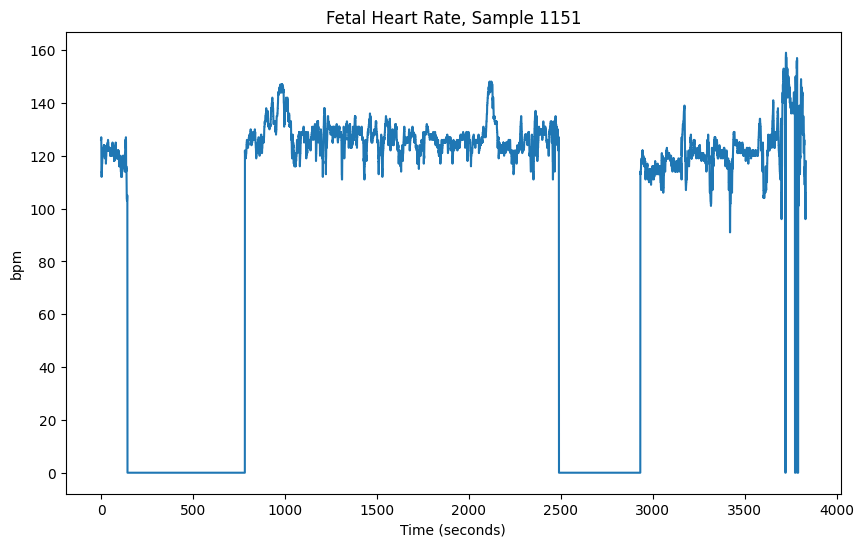

In [ ]:
import matplotlib.pyplot as plt

def plot_fhr(fhr, title, hz4 = True):

    plt.figure(figsize=(10, 6))
    plt.plot(fhr)
    plt.xlabel("Time (seconds)")  # Adjusted to represent time in seconds
    plt.ylabel("bpm")
    plt.title(title)

    # Set the x-ticks to represent seconds
    ticks = plt.gca().get_xticks()
    if hz4:
        plt.gca().set_xticklabels([int(round(tick/4, 2)) for tick in ticks])  # Divide by 4 to convert to seconds
    plt.show()

plot_fhr(fhrs_df_14k.iloc[16, :],title = "Fetal Heart Rate, Sample 1151")

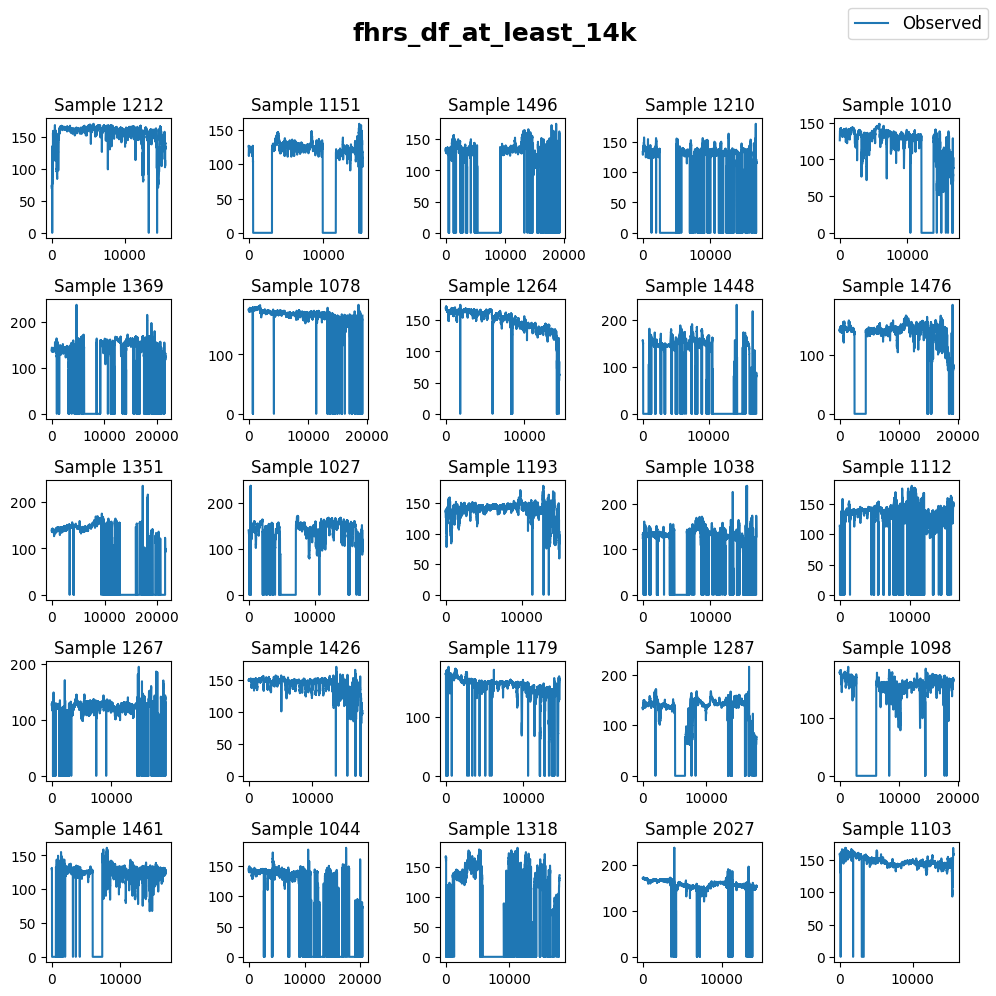

In [ ]:
plot_5x5_subplots(fhrs_df_14k.select_dtypes(include = "number"), title = "fhrs_df_at_least_14k")

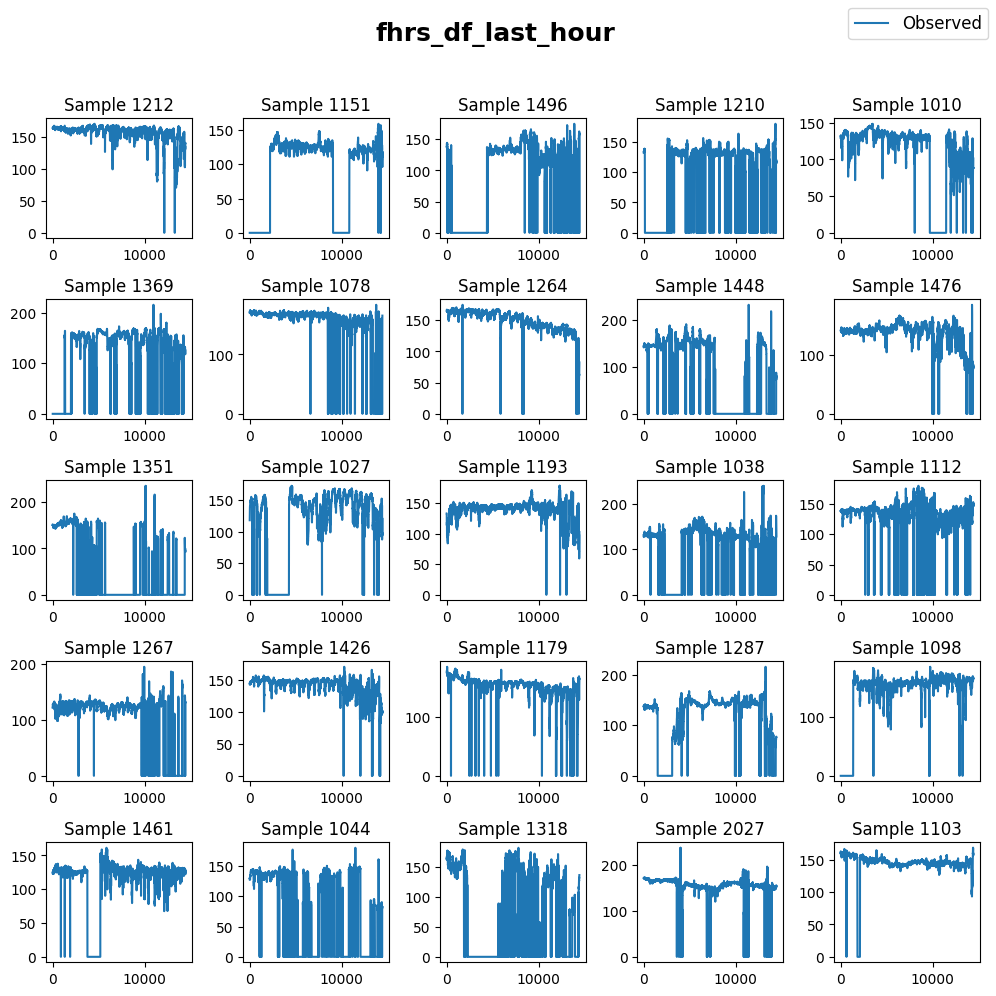

In [ ]:
plot_5x5_subplots(fhrs_df_last_hour.select_dtypes(include = "number"), title = "fhrs_df_last_hour")

In [ ]:
def has_long_zero_sequence(row, threshold):
    """
    Check if a row contains a sequence of zeros longer than the threshold.

    Parameters:
        row (pd.Series or np.array): The row (time series) to check.
        threshold (int): The minimum length of consecutive zeros to detect.

    Returns:
        bool: True if a sequence of zeros longer than the threshold is found, otherwise False.
    """
    zero_counts = 0
    for value in row:
        if value == 0:
            zero_counts += 1
            if zero_counts > threshold:
                return True
        else:
            zero_counts = 0  # Reset counter when encountering a non-zero value
    return False

In [ ]:
fhrs_df_last_hour['has_long_zero_sequence_1min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*1*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_2min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*2*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_3min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*3*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_4min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*4*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_5min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*5*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_6min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*6*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_7min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*7*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_8min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*8*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_9min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*9*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_10min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*10*4), axis=1)
fhrs_df_last_hour['has_long_zero_sequence_20min'] = fhrs_df_last_hour.apply(lambda row: has_long_zero_sequence(row, 60*20*4), axis=1)


In [ ]:
fhrs_df_last_hour_no_1min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_1min']].select_dtypes(include = "number") # 247 rows
fhrs_df_last_hour_no_2min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_2min']].select_dtypes(include = "number") # 326 rows
fhrs_df_last_hour_no_3min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_3min']].select_dtypes(include = "number") # 344 rows
fhrs_df_last_hour_no_4min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_4min']].select_dtypes(include = "number")
fhrs_df_last_hour_no_5min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_5min']].select_dtypes(include = "number")
fhrs_df_last_hour_no_6min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_6min']].select_dtypes(include = "number")
fhrs_df_last_hour_no_7min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_7min']].select_dtypes(include = "number")
fhrs_df_last_hour_no_8min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_8min']].select_dtypes(include = "number")
fhrs_df_last_hour_no_9min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_9min']].select_dtypes(include = "number")
fhrs_df_last_hour_no_10min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_10min']].select_dtypes(include = "number")
fhrs_df_last_hour_no_20min_gaps = fhrs_df_last_hour[~fhrs_df_last_hour['has_long_zero_sequence_20min']].select_dtypes(include = "number")


In [ ]:
print("sample for 1min:",fhrs_df_last_hour_no_1min_gaps.shape[0])
print("sample for 2min:",fhrs_df_last_hour_no_2min_gaps.shape[0])
print("sample for 3min:",fhrs_df_last_hour_no_3min_gaps.shape[0])
print("sample for 4min:",fhrs_df_last_hour_no_4min_gaps.shape[0])
print("sample for 5min:",fhrs_df_last_hour_no_5min_gaps.shape[0])
print("sample for 6min:",fhrs_df_last_hour_no_6min_gaps.shape[0])
print("sample for 7min:",fhrs_df_last_hour_no_7min_gaps.shape[0])
print("sample for 8min:",fhrs_df_last_hour_no_8min_gaps.shape[0])
print("sample for 9min:",fhrs_df_last_hour_no_9min_gaps.shape[0])
print("sample for 10min:",fhrs_df_last_hour_no_10min_gaps.shape[0])
print("sample for 20min:",fhrs_df_last_hour_no_20min_gaps.shape[0])

sample for 1min: 247
sample for 2min: 326
sample for 3min: 344
sample for 4min: 364
sample for 5min: 375
sample for 6min: 389
sample for 7min: 402
sample for 8min: 419
sample for 9min: 433
sample for 10min: 448
sample for 20min: 502


In [ ]:
ucs_df_last_hour_no_2min_gaps = ucs_df_last_hour.loc[fhrs_df_last_hour_no_2min_gaps.index]
ucs_df_last_hour_no_20min_gaps = ucs_df_last_hour.loc[fhrs_df_last_hour_no_20min_gaps.index]

In [ ]:
fhrs_df_last_hour_no_2min_gaps_linear_interp = fhrs_df_last_hour_no_2min_gaps.replace(0, np.nan).interpolate(method='linear', axis=1)
fhrs_df_last_hour_no_20min_gaps_linear_interp = fhrs_df_last_hour_no_20min_gaps.replace(0, np.nan).interpolate(method='linear', axis=1)

In [ ]:
fhrs_df_last_hour_no_2min_gaps.columns = range(fhrs_df_last_hour_no_2min_gaps.shape[1])
fhrs_df_last_hour_no_2min_gaps_cubic_interp = fhrs_df_last_hour_no_2min_gaps.replace(0, np.nan).interpolate(method='cubic', axis=1)

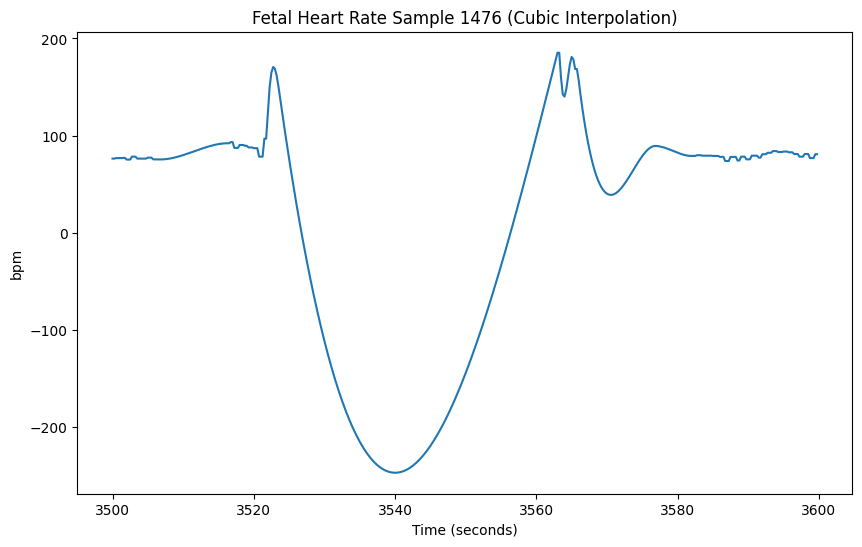

In [ ]:
import matplotlib.pyplot as plt

# Slice the data (for sample 18 and from index 14000 onwards)
data = fhrs_df_last_hour_no_2min_gaps_cubic_interp.iloc[18, 14000:]

# Create a time vector in seconds, corresponding to each data point
time = [3500 + i / 4 for i in range(len(data))]  # Dividing by 4 to convert from 4 Hz to seconds

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, data)

# Label the axes and title
plt.xlabel("Time (seconds)")
plt.ylabel("bpm")
plt.title("Fetal Heart Rate Sample 1476 (Cubic Interpolation)")

plt.show()


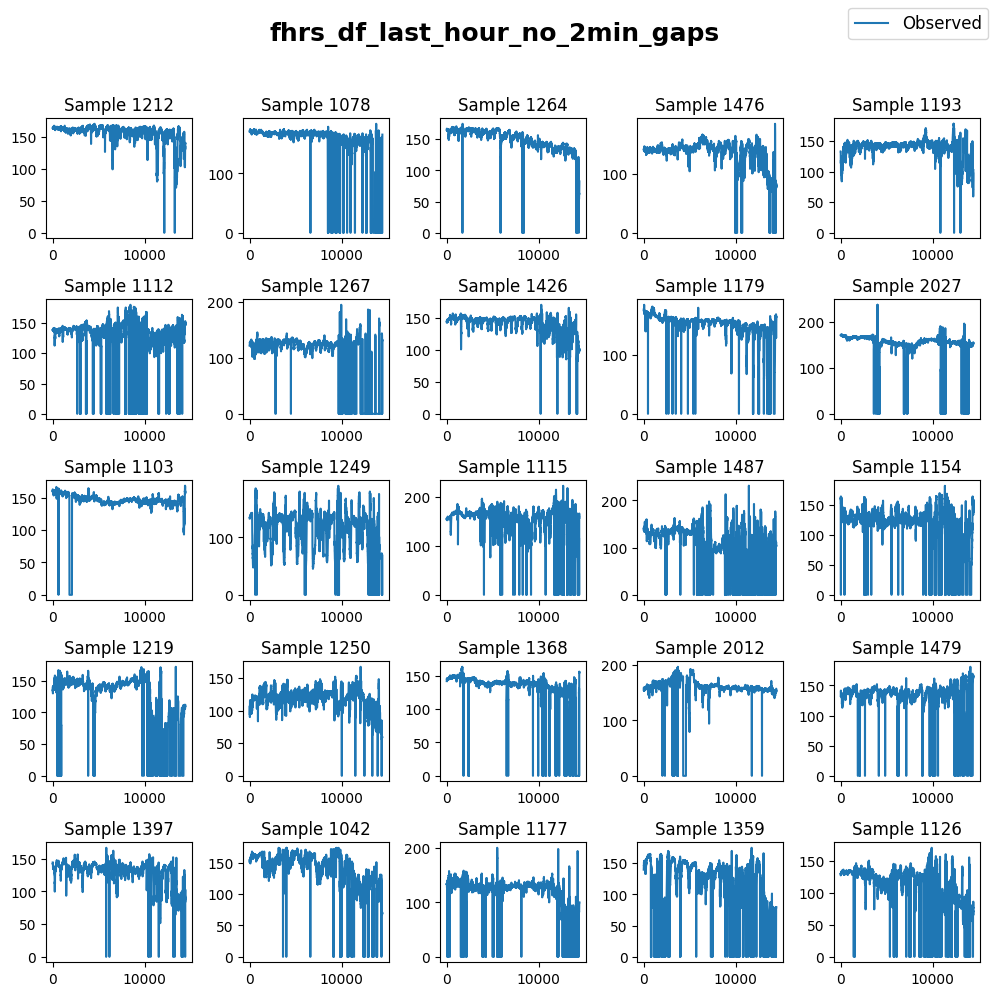

In [ ]:
plot_5x5_subplots(fhrs_df_last_hour_no_2min_gaps, title= "fhrs_df_last_hour_no_2min_gaps")

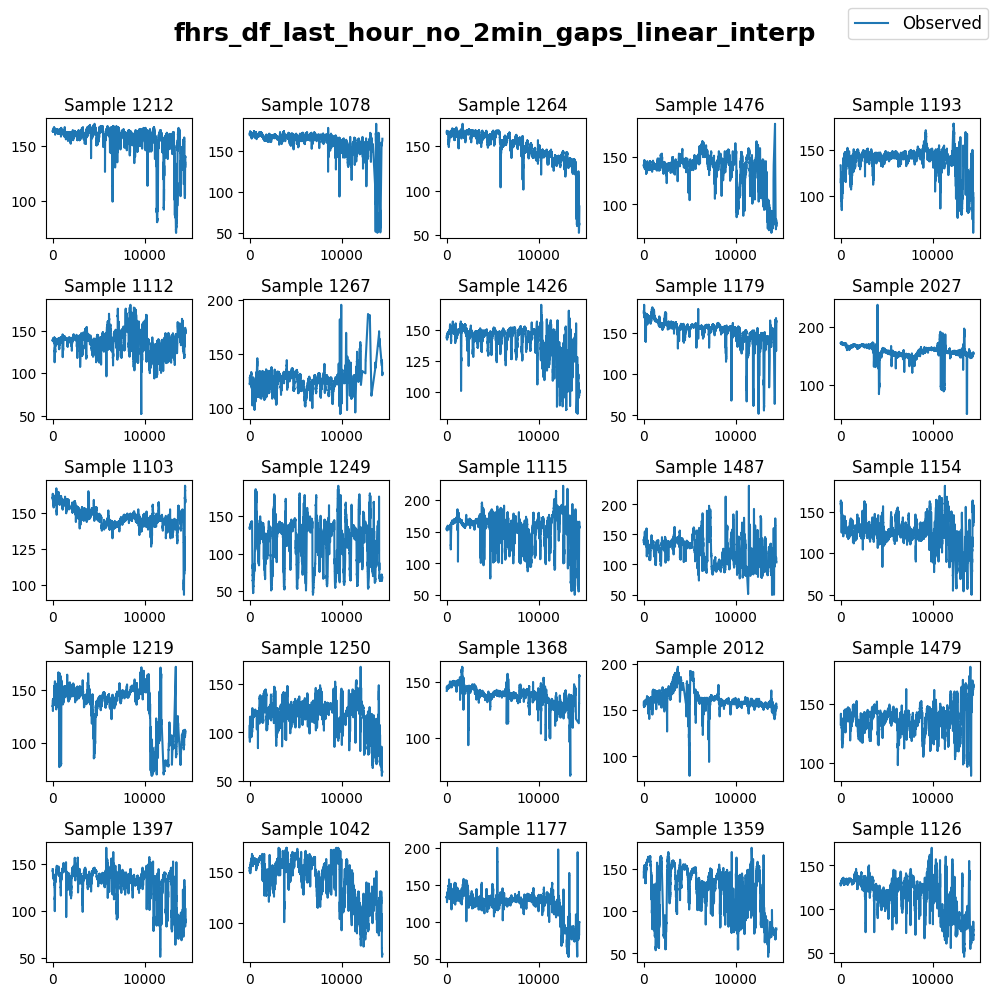

In [ ]:
plot_5x5_subplots(fhrs_df_last_hour_no_2min_gaps_linear_interp, title = "fhrs_df_last_hour_no_2min_gaps_linear_interp")

<ipython-input-21-d5d782f14e84>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([int(round(tick/4, 2)) for tick in ticks])  # Divide by 4 to convert to seconds


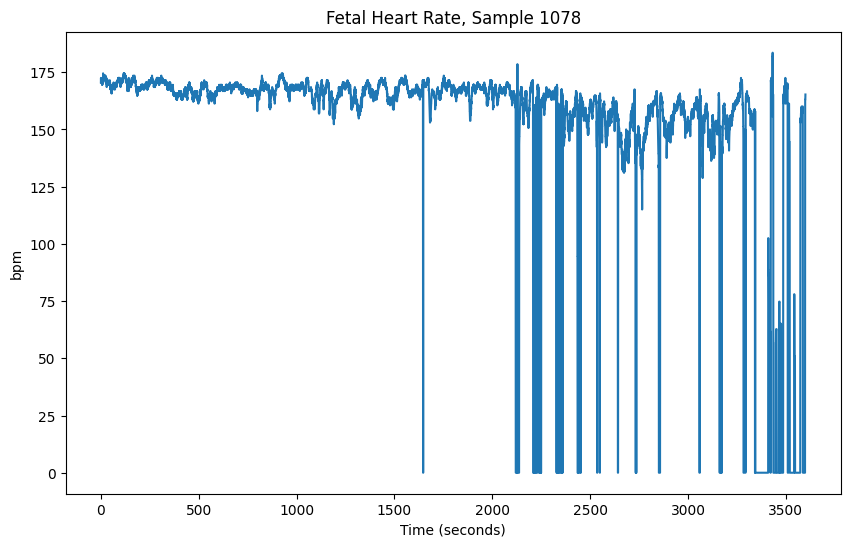

In [ ]:
plot_fhr(fhrs_df_last_hour_no_2min_gaps.iloc[16, :],title = "Fetal Heart Rate, Sample 1078")

<ipython-input-21-d5d782f14e84>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([int(round(tick/4, 2)) for tick in ticks])  # Divide by 4 to convert to seconds


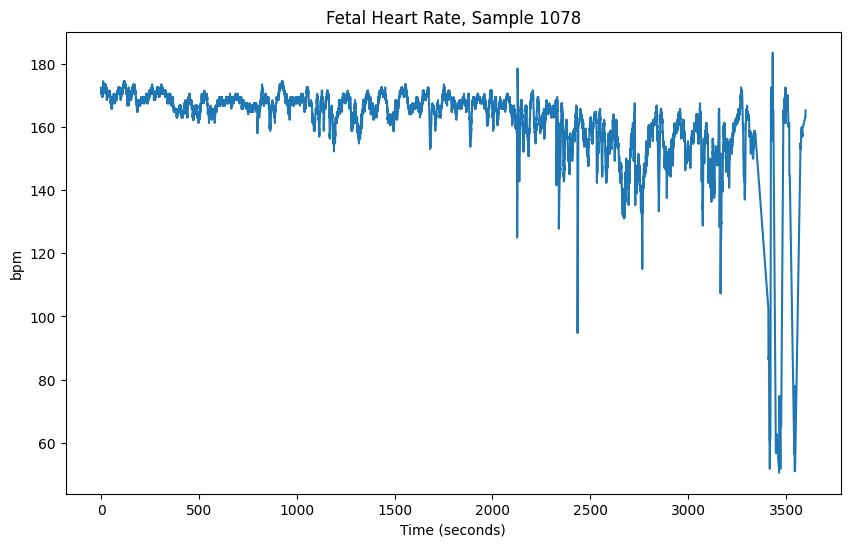

In [ ]:
plot_fhr(fhrs_df_last_hour_no_2min_gaps_linear_interp.iloc[16, :],title = "Fetal Heart Rate, Sample 1078")

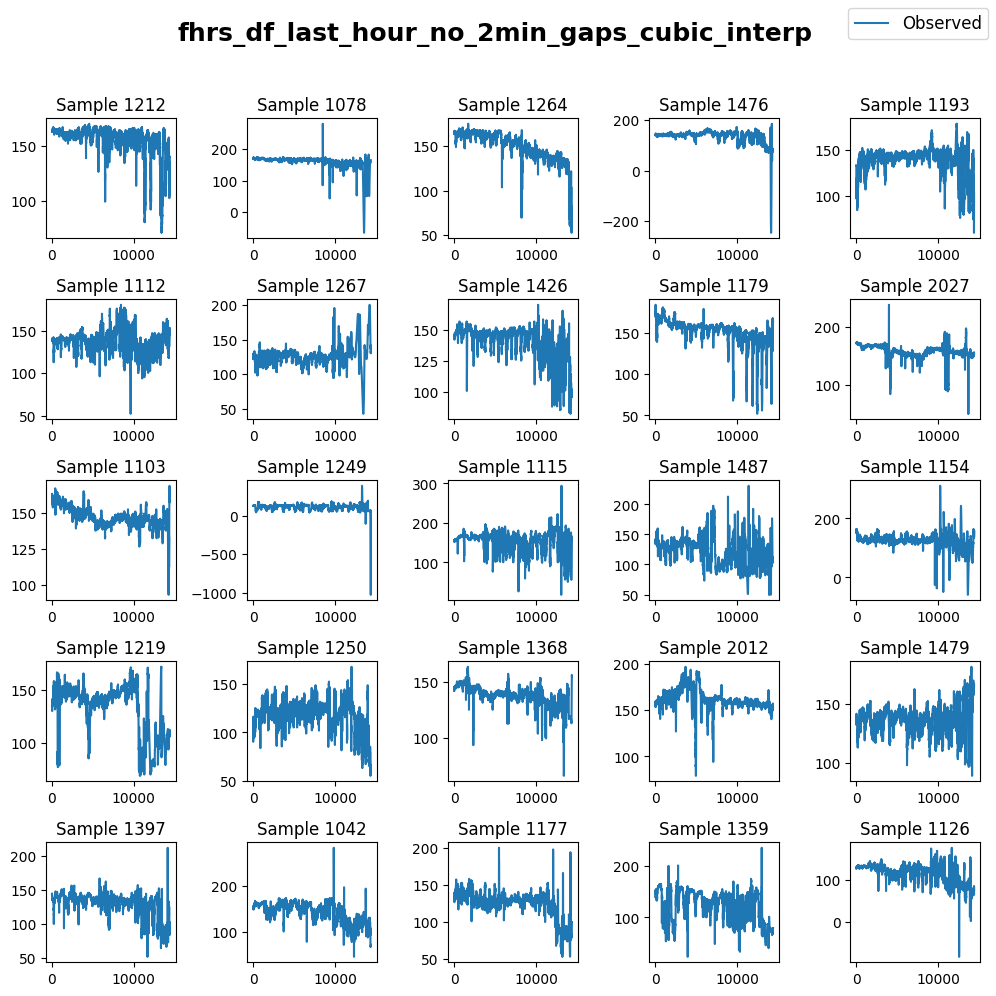

In [ ]:
plot_5x5_subplots(fhrs_df_last_hour_no_2min_gaps_cubic_interp, title = "fhrs_df_last_hour_no_2min_gaps_cubic_interp")
# Thats bad cause it has negative values.

In [ ]:
import pandas as pd

# Assuming fhrs_df_last_hour_no_2min_gaps_linear_interp is your DataFrame
fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz = fhrs_df_last_hour_no_2min_gaps_linear_interp.groupby(
    lambda x: x // 4, axis=1
).mean()

fhrs_df_last_hour_no_20min_gaps_linear_interp_mean1hz = fhrs_df_last_hour_no_20min_gaps_linear_interp.groupby(
    lambda x: x // 4, axis=1
).mean()

fhrs_df_last_hour_no_20min_gaps_mean1hz = fhrs_df_last_hour_no_20min_gaps.groupby(
    lambda x: x // 4, axis=1
).mean()

ucs_df_last_hour_no_2min_gaps_mean1hz = ucs_df_last_hour_no_2min_gaps.groupby(
    lambda x: x // 4, axis=1
).mean()

ucs_df_last_hour_no_20min_gaps_mean1hz = ucs_df_last_hour_no_20min_gaps.groupby(
    lambda x: x // 4, axis=1
).mean()


<ipython-input-37-90c4d6bfb96b>:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz = fhrs_df_last_hour_no_2min_gaps_linear_interp.groupby(
<ipython-input-37-90c4d6bfb96b>:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  fhrs_df_last_hour_no_20min_gaps_linear_interp_mean1hz = fhrs_df_last_hour_no_20min_gaps_linear_interp.groupby(
<ipython-input-37-90c4d6bfb96b>:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  fhrs_df_last_hour_no_20min_gaps_mean1hz = fhrs_df_last_hour_no_20min_gaps.groupby(
<ipython-input-37-90c4d6bfb96b>:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ucs_df_last_hour_no_2min_gaps_mean1hz = ucs_df_last_hour_no_2min_gaps.groupby(
<ipython-input-37-90c4d6bfb96b>:20: 

In [ ]:
try:
  labels.index = labels['sample']
  labels.drop('sample', axis=1, inplace=True)
except:
  pass

In [ ]:
labels.index = labels.index.astype(str)
labels.index.name = "sample-id"

labels_no_2min_gaps = labels.loc[fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz.index]
labels_no_20min_gaps = labels.loc[fhrs_df_last_hour_no_20min_gaps_linear_interp_mean1hz.index]

labels_no_2min_gaps.index.name = "sample-id"
labels_no_20min_gaps.index.name = "sample-id"

import os
if not os.path.exists("/content/labels"):
  os.makedirs("/content/labels")

labels_no_2min_gaps.to_csv("/content/labels/labels_no_2min_gaps.csv")
labels_no_20min_gaps.to_csv("/content/labels/labels_no_20min_gaps.csv")

In [ ]:
def create_tensor(fhr_df, uc_df):
    fhr_tensor = torch.tensor(fhr_df.values, dtype=torch.float32)
    uc_tensor = torch.tensor(uc_df.values, dtype=torch.float32)

    # Stack them along the last dimension (axis=-1)
    combined_tensor = torch.stack((fhr_tensor, uc_tensor), dim=-1)

    # Permute the tensor to [508, 2, 14400]
    combined_tensor = combined_tensor.permute(0, 2, 1)

    return combined_tensor

last_hour_no_2min_gaps_linear_interp_mean1hz_tensor = create_tensor(fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz, ucs_df_last_hour_no_2min_gaps_mean1hz)
last_hour_no_20min_gaps_linear_interp_mean1hz_tensor = create_tensor(fhrs_df_last_hour_no_20min_gaps_linear_interp_mean1hz, ucs_df_last_hour_no_20min_gaps_mean1hz)
last_hour_no_20min_gaps_mean1hz_tensor = create_tensor(fhrs_df_last_hour_no_20min_gaps, ucs_df_last_hour_no_20min_gaps)



In [ ]:
fhrs_df_last_hour_no_2min_gaps.iloc[46,:]

,1140
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
...,...
14395,105.00
14396,105.00
14397,106.50
14398,106.50


In [ ]:
ucs_df_last_hour_no_2min_gaps_mean1hz

,0,1,2,3,4,5,6,7,8,9,...,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599
1258,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,...,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500
1301,15.125,14.625,14.000,13.250,13.125,13.000,13.000,12.875,12.875,13.125,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1203,16.750,16.000,15.750,14.375,13.750,13.000,12.625,11.625,10.250,8.875,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.125,0.000
1068,33.000,33.000,33.750,34.000,34.000,34.000,34.000,34.000,34.000,34.250,...,12.000,12.000,11.500,12.000,12.000,12.000,12.000,12.000,12.000,12.000
1490,28.250,29.250,29.375,30.000,29.125,28.875,29.750,32.250,35.250,32.125,...,32.625,34.875,42.375,44.125,32.125,25.500,20.250,21.125,21.750,29.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,12.500,14.250,13.250,14.250,14.750,13.250,14.500,12.500,13.250,14.500,...,1.750,1.750,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000
1385,9.000,9.125,10.250,9.500,8.875,9.625,9.125,8.750,8.250,9.000,...,25.500,27.125,29.125,26.625,24.250,23.625,23.500,23.625,25.625,25.375
1065,22.250,27.125,22.125,13.250,13.250,19.250,18.625,11.250,7.250,13.875,...,16.750,16.500,16.375,16.250,15.875,16.125,16.125,16.125,16.375,16.625
1229,6.625,6.750,5.625,5.500,5.875,5.000,5.625,5.250,5.500,6.750,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
if not os.path.exists("/content/tensors"):
  os.makedirs("/content/tensors")

torch.save(last_hour_no_2min_gaps_linear_interp_mean1hz_tensor, "/content/tensors/last_hour_no_2min_gaps_linear_interp_mean1hz_tensor.pt")
torch.save(last_hour_no_20min_gaps_linear_interp_mean1hz_tensor, "/content/tensors/last_hour_no_20min_gaps_linear_interp_mean1hz_tensor.pt")
torch.save(last_hour_no_20min_gaps_mean1hz_tensor, "/content/tensors/last_hour_no_20min_gaps_mean1hz_tensor.pt")

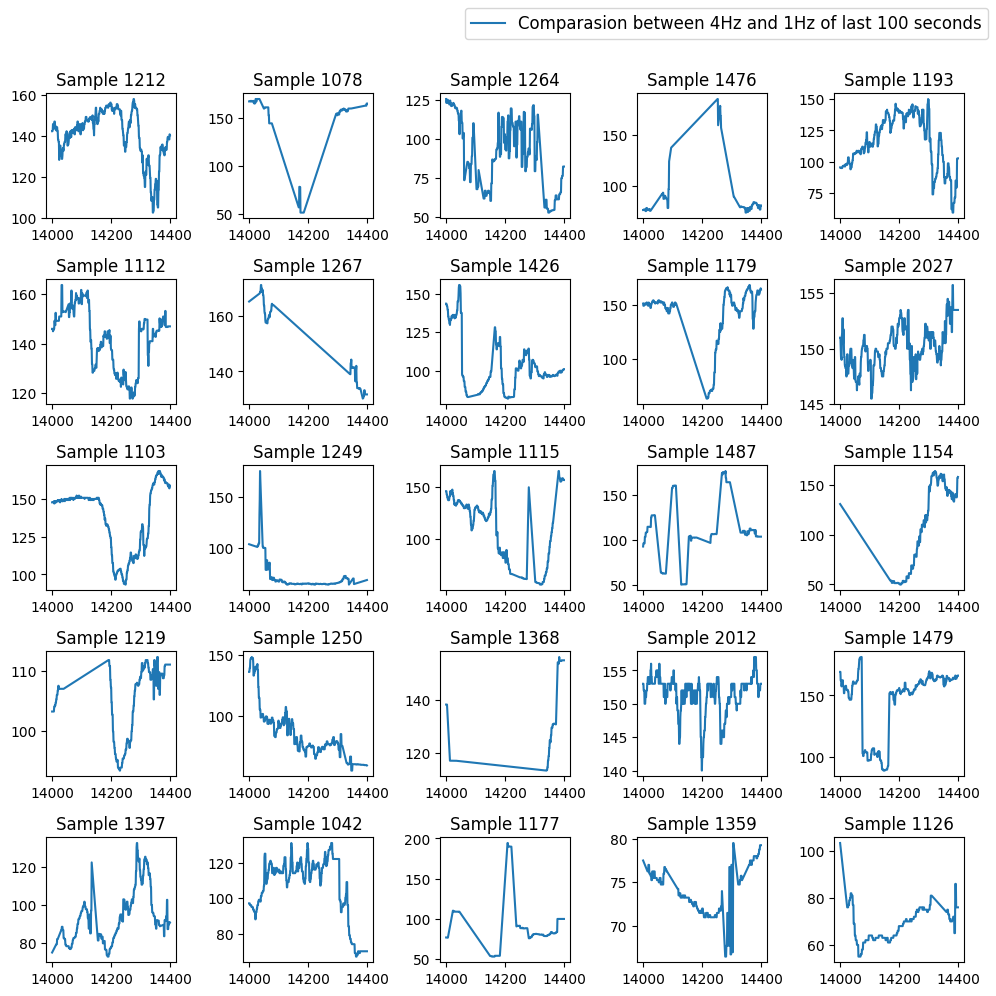

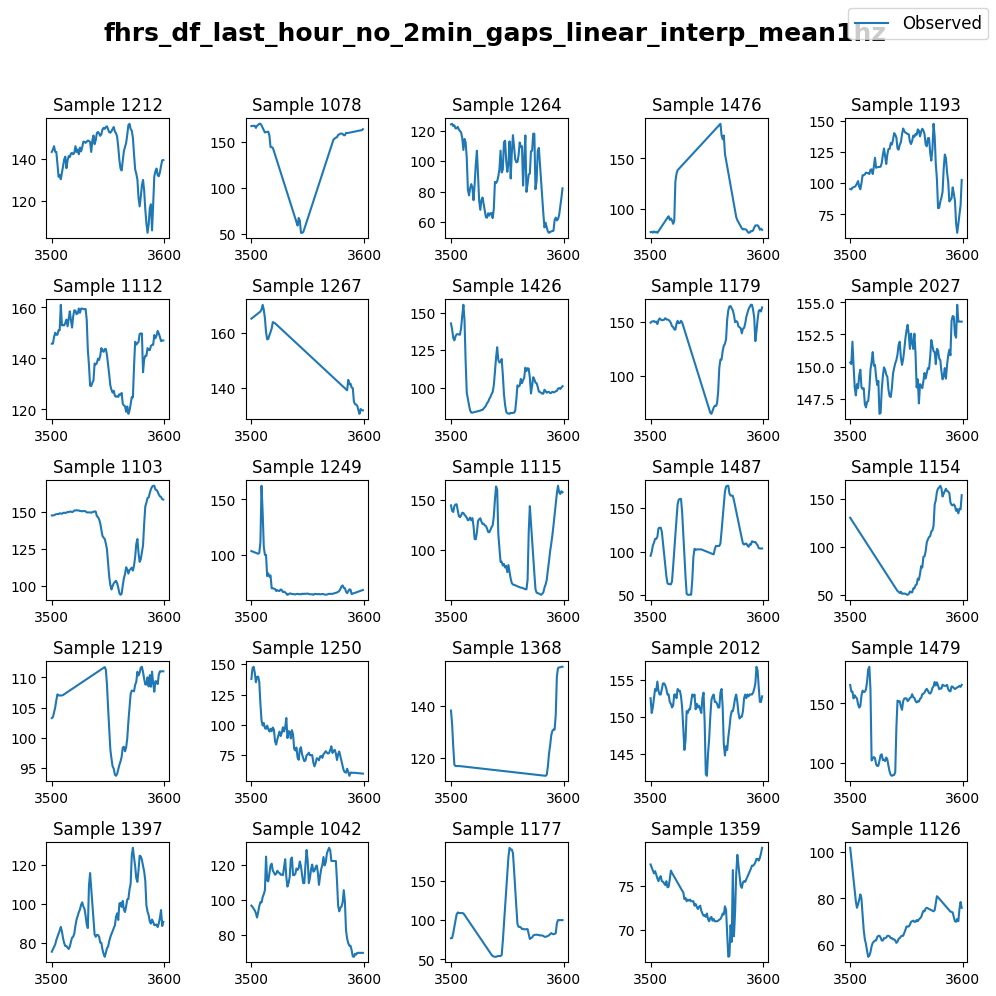

In [ ]:
plot_5x5_subplots(fhrs_df_last_hour_no_2min_gaps_linear_interp.iloc[:,-400:], "Comparasion between 4Hz and 1Hz of last 100 seconds")
plot_5x5_subplots(fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz.iloc[:,-100:],title="fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz")

We will carry on with linear interpolation (no negative values) on last hour seqs with no gaps (zero subseqs) of more than 2 min, mean to 1Hz

In [ ]:
fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz.iloc[15]

,1212
0,164.0000
1,164.0000
2,163.7500
3,163.0000
4,163.0000
...,...
3595,131.6250
3596,133.5625
3597,136.5625
3598,139.2500


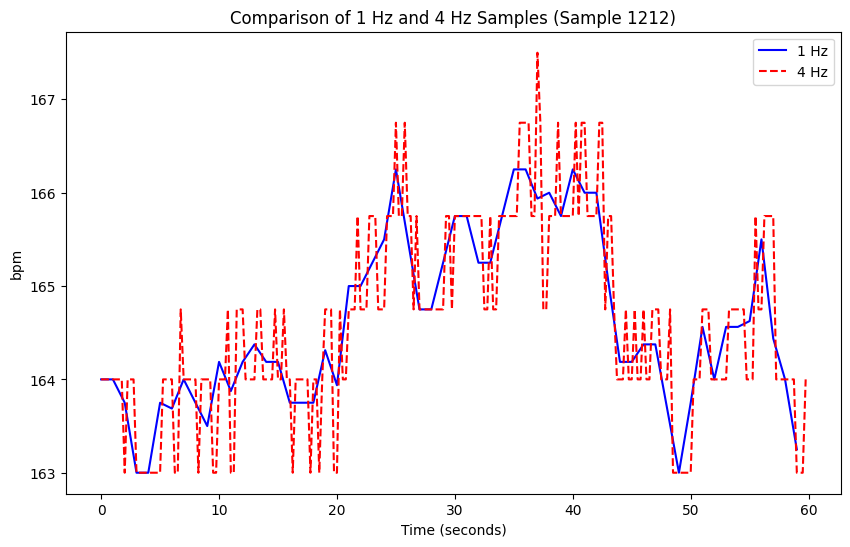

In [ ]:
import matplotlib.pyplot as plt

# Assuming these two are the relevant samples
sample_1hz = fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz.iloc[15,:60]  # 60 data points (1 Hz)
sample_4hz = fhrs_df_last_hour_no_2min_gaps_linear_interp.iloc[15,:240]  # 240 data points (4 Hz)

# Plot both samples on the same plot


# Create time values for both signals
time_1hz = range(0, 60)  # 60 seconds for 1 Hz signal
time_4hz = [i / 4 for i in range(240)]  # 240 data points, scaled to time for 4 Hz signal

# Plot both samples on the same plot
plt.figure(figsize=(10, 6))

# Plot 1 Hz sample
plt.plot(time_1hz, sample_1hz, label='1 Hz', linestyle='-', color='b')

# Plot 4 Hz sample
plt.plot(time_4hz, sample_4hz, label='4 Hz', linestyle='--', color='r')

# Add labels and title
plt.xlabel("Time (seconds)")
plt.ylabel("bpm")
plt.title("Comparison of 1 Hz and 4 Hz Samples (Sample 1212)")

# Add a legend
plt.legend()

plt.show()

#### timer-base-84m

In [ ]:
fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz
labels = pd.read_csv("/content/drive/MyDrive/Msc/Other Projects/RAJA/labels.csv")

In [ ]:
# Create Sin function to see prediction.

import torch
from transformers import AutoModelForCausalLM

# load pretrain model
model = AutoModelForCausalLM.from_pretrained('thuml/timer-base-84m', trust_remote_code=True)

# prepare input
batch_size, lookback_length = 1, 2880
t = np.linspace(0, 20 * np.pi, lookback_length)  # Time variable
seqs_np = np.sin(t)  # Sinusoidal sequence

# Convert to tensor (required for the model)
seqs = torch.tensor(seqs_np, dtype=torch.float32).unsqueeze(0)
# generate forecast
prediction_length = 96
output = model.generate(seqs, max_new_tokens=prediction_length)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

configuration_timer.py:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/thuml/timer-base-84m:
- configuration_timer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_timer.py:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

ts_generation_mixin.py:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/thuml/timer-base-84m:
- ts_generation_mixin.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/thuml/timer-base-84m:
- modeling_timer.py
- ts_generation_mixin.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/337M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [ ]:
import torch
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from transformers import AutoModelForCausalLM


def plot_forecast(seqs_np, pred_values, seqs_np_len_to_plot = None):
# Create time indices
    if seqs_np_len_to_plot is None:
      seqs_np_len_to_plot = len(seqs_np)

    history_time = np.arange(len(seqs_np))  # Time indices for input sequence
    forecast_time = np.arange(len(seqs_np), len(seqs_np) + pred_values.shape[0])  # Time for prediction

    # Initialize Plotly figure
    fig = go.Figure()

    # Plot the historical input sequence
    fig.add_trace(go.Scatter(
        x=history_time, y=seqs_np,
        mode='lines', line=dict(color='blue'),
        name='Input Sequence'
    ))

    # Plot the model's predictions
    fig.add_trace(go.Scatter(
        x=forecast_time, y=pred_values,
        mode='lines', line=dict(color='black', dash='dash'),
        name='Predicted Values'
    ))

    # Add a vertical line to separate history from predictions
    fig.add_vline(x=len(seqs_np), line=dict(color="red", width=2, dash="dot"), name="Forecast Start")

    # Update layout
    fig.update_layout(
        title="Time Series Forecast",
        xaxis_title="Time Steps",
        yaxis_title="Value",
        legend_title="Legend",
        template="plotly_white"
    )

    # Show plot
    fig.show()



# Convert tensors to NumPy
seqs_np = seqs.squeeze().detach().cpu().numpy()
pred_values = output.squeeze().detach().cpu().numpy()

plot_forecast(seqs_np, pred_values)

In [ ]:
input = torch.from_numpy(fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz.iloc[:,:-400].values).float() # [326, 3200]

In [ ]:
batch_size, lookback_length = input.shape[0], 1000

# generate forecast
prediction_length = 96
output = model.generate(input, max_new_tokens=96)

In [ ]:
for i in range(5):
  plot_forecast(input[i,-1000:],output[i])

### Chronos Amazon

In [ ]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 85.1 MB/s eta 0:00:00


In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

Next, we create the TimeSeriesPredictor and select the "bolt_small" presets to use the Chronos-Bolt (Small, 48M)

In [ ]:
import pandas as pd

# Assuming 'df' is your original DataFrame (samples as rows, timesteps as columns)
df = fhrs_df_last_hour_no_2min_gaps_linear_interp_mean1hz.copy().T

# # Number of timesteps (columns) in your data
num_timesteps = df.shape[0]

# # Create timestamps assuming 1 second frequency starting from a specific date (e.g., '2019-01-01 00:00:00')
timestamps = pd.date_range(start='00:00:00', periods=num_timesteps, freq='1s')

df['timestamp'] = timestamps
df_timeseries = pd.wide_to_long(df, stubnames='', i=['timestamp'], j='item_id')
df_timeseries.columns = ['target']
df_timeseries = df_timeseries.reorder_levels(['item_id', 'timestamp'])


In [ ]:
timeseriesdataframe = TimeSeriesDataFrame.from_data_frame(df_timeseries)

In [ ]:
!pip install peft==0.10.0;  #Prevent 'EncoderDecoderCache' from 'transformers' problem in training

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.14.0
    Uninstalling peft-0.14.0:
      Successfully uninstalled peft-0.14.0


#### Zero shot

In [ ]:
prediction_length = 48
train_data, test_data = timeseriesdataframe.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
    enable_ensemble = "False"
)

Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250316_080631'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.30 GB / 12.67 GB (65.5%)
Disk Space Avail:   64.84 GB / 107.72 GB (60.2%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': 'False',
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2

As promised, Chronos does not take any time to fit. The fit call merely serves as a proxy for the TimeSeriesPredictor to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk.

Chronos models do not really fit time series data. However, when predict is called, they carry out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, where all computation happens during inference.

Here we used the "medium_quality" presets and limited the training time to 10 minutes (600 seconds). The presets define which models AutoGluon will try to fit. For medium_quality presets, these are simple baselines (Naive, SeasonalNaive), statistical models (ETS, Theta), tree-based models based on LightGBM (RecursiveTabular, DirectTabular), a deep learning model TemporalFusionTransformer, and a weighted ensemble combining these. Other available presets for TimeSeriesPredictor are "fast_training", "high_quality" and "best_quality". Higher quality presets will usually produce more accurate forecasts but take longer to train.

In [ ]:
predictor_zeroshot = TimeSeriesPredictor(
    prediction_length=48,
    target="target",
    eval_metric="MASE",
)

predictor_zeroshot.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20250316_082915'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.01 GB / 12.67 GB (47.4%)
Disk Space Avail:   64.13 GB / 107.72 GB (59.5%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 's'
Provided train_data ha

In [ ]:
predictions = predictor_zeroshot.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [ ]:
print(predictor_zeroshot.leaderboard())

                       model  score_val  pred_time_val  fit_time_marginal  \
0           WeightedEnsemble  -8.172397      66.511964           1.928890   
1        Chronos[bolt_small]  -8.348320      38.636528           0.529303   
2  TemporalFusionTransformer  -8.572931       1.605641         125.940567   
3           RecursiveTabular  -8.725824       2.628033          62.469062   
4              SeasonalNaive  -8.972578       0.763050           2.660711   
5                      Naive  -8.972578       3.039110           3.105841   
6                        ETS  -9.541217      20.489804           1.431511   
7              DirectTabular  -9.989538       3.151958          81.696088   

   fit_order  
0          8  
1          6  
2          7  
3          3  
4          2  
5          1  
6          5  
7          4  


In [ ]:
predictor_zeroshot._learner.trainer.__dict__

{'path': '/content/AutogluonModels/ag-20250316_082915/models',
 'reset_paths': False,
 'low_memory': True,
 'save_data': True,
 'models': {},
 'model_graph': <networkx.classes.digraph.DiGraph at 0x7a6f2d501110>,
 'model_best': 'WeightedEnsemble',
 '_extra_banned_names': set(),
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'target': 'target',
 'metadata': CovariateMetadata(static_features_cat=[], static_features_real=[], known_covariates_real=[], known_covariates_cat=[], past_covariates_real=[], past_covariates_cat=[]),
 'is_data_saved': True,
 'skip_model_selection': False,
 'enable_ensemble': True,
 'ensemble_model_type': autogluon.timeseries.models.ensemble.greedy_ensemble.TimeSeriesGreedyEnsemble,
 'verbosity': 2,
 'model_refit_map': {},
 'eval_metric': MASE,
 'eval_metric_seasonal_period': None,
 'val_splitter': <autogluon.timeseries.splitter.ExpandingWindowSplitter at 0x7a6e40d37f90>,
 'refit_every_n_windows': 1,
 'cache_predictions'

In [ ]:
import pickle

model_path = "/content/AutogluonModels/ag-20250316_082915/models/Chronos[bolt_small]/model.pkl"

with open(model_path, "rb") as f:
    chronos_model = pickle.load(f)

In [ ]:
type(chronos_model)

autogluon.timeseries.models.multi_window.multi_window_model.MultiWindowBacktestingModel

In [ ]:
import pickle
import torch

# Load the actual PyTorch model
chronos_model_pathW0 = "/content/AutogluonModels/ag-20250316_082915/models/Chronos[bolt_small]/W0/model.pkl"

with open(chronos_model_pathW0, "rb") as f:
    chronos_modelW0 = pickle.load(f)

print(type(chronos_modelW0))  # Should show a PyTorch model


<class 'autogluon.timeseries.models.chronos.model.ChronosModel'>


In [ ]:
chronos_model_pathoof = "/content/AutogluonModels/ag-20250316_082915/models/Chronos[bolt_small]/utils/oof.pkl"

with open(chronos_model_pathoof, "rb") as f:
    chronos_modeloof = pickle.load(f)

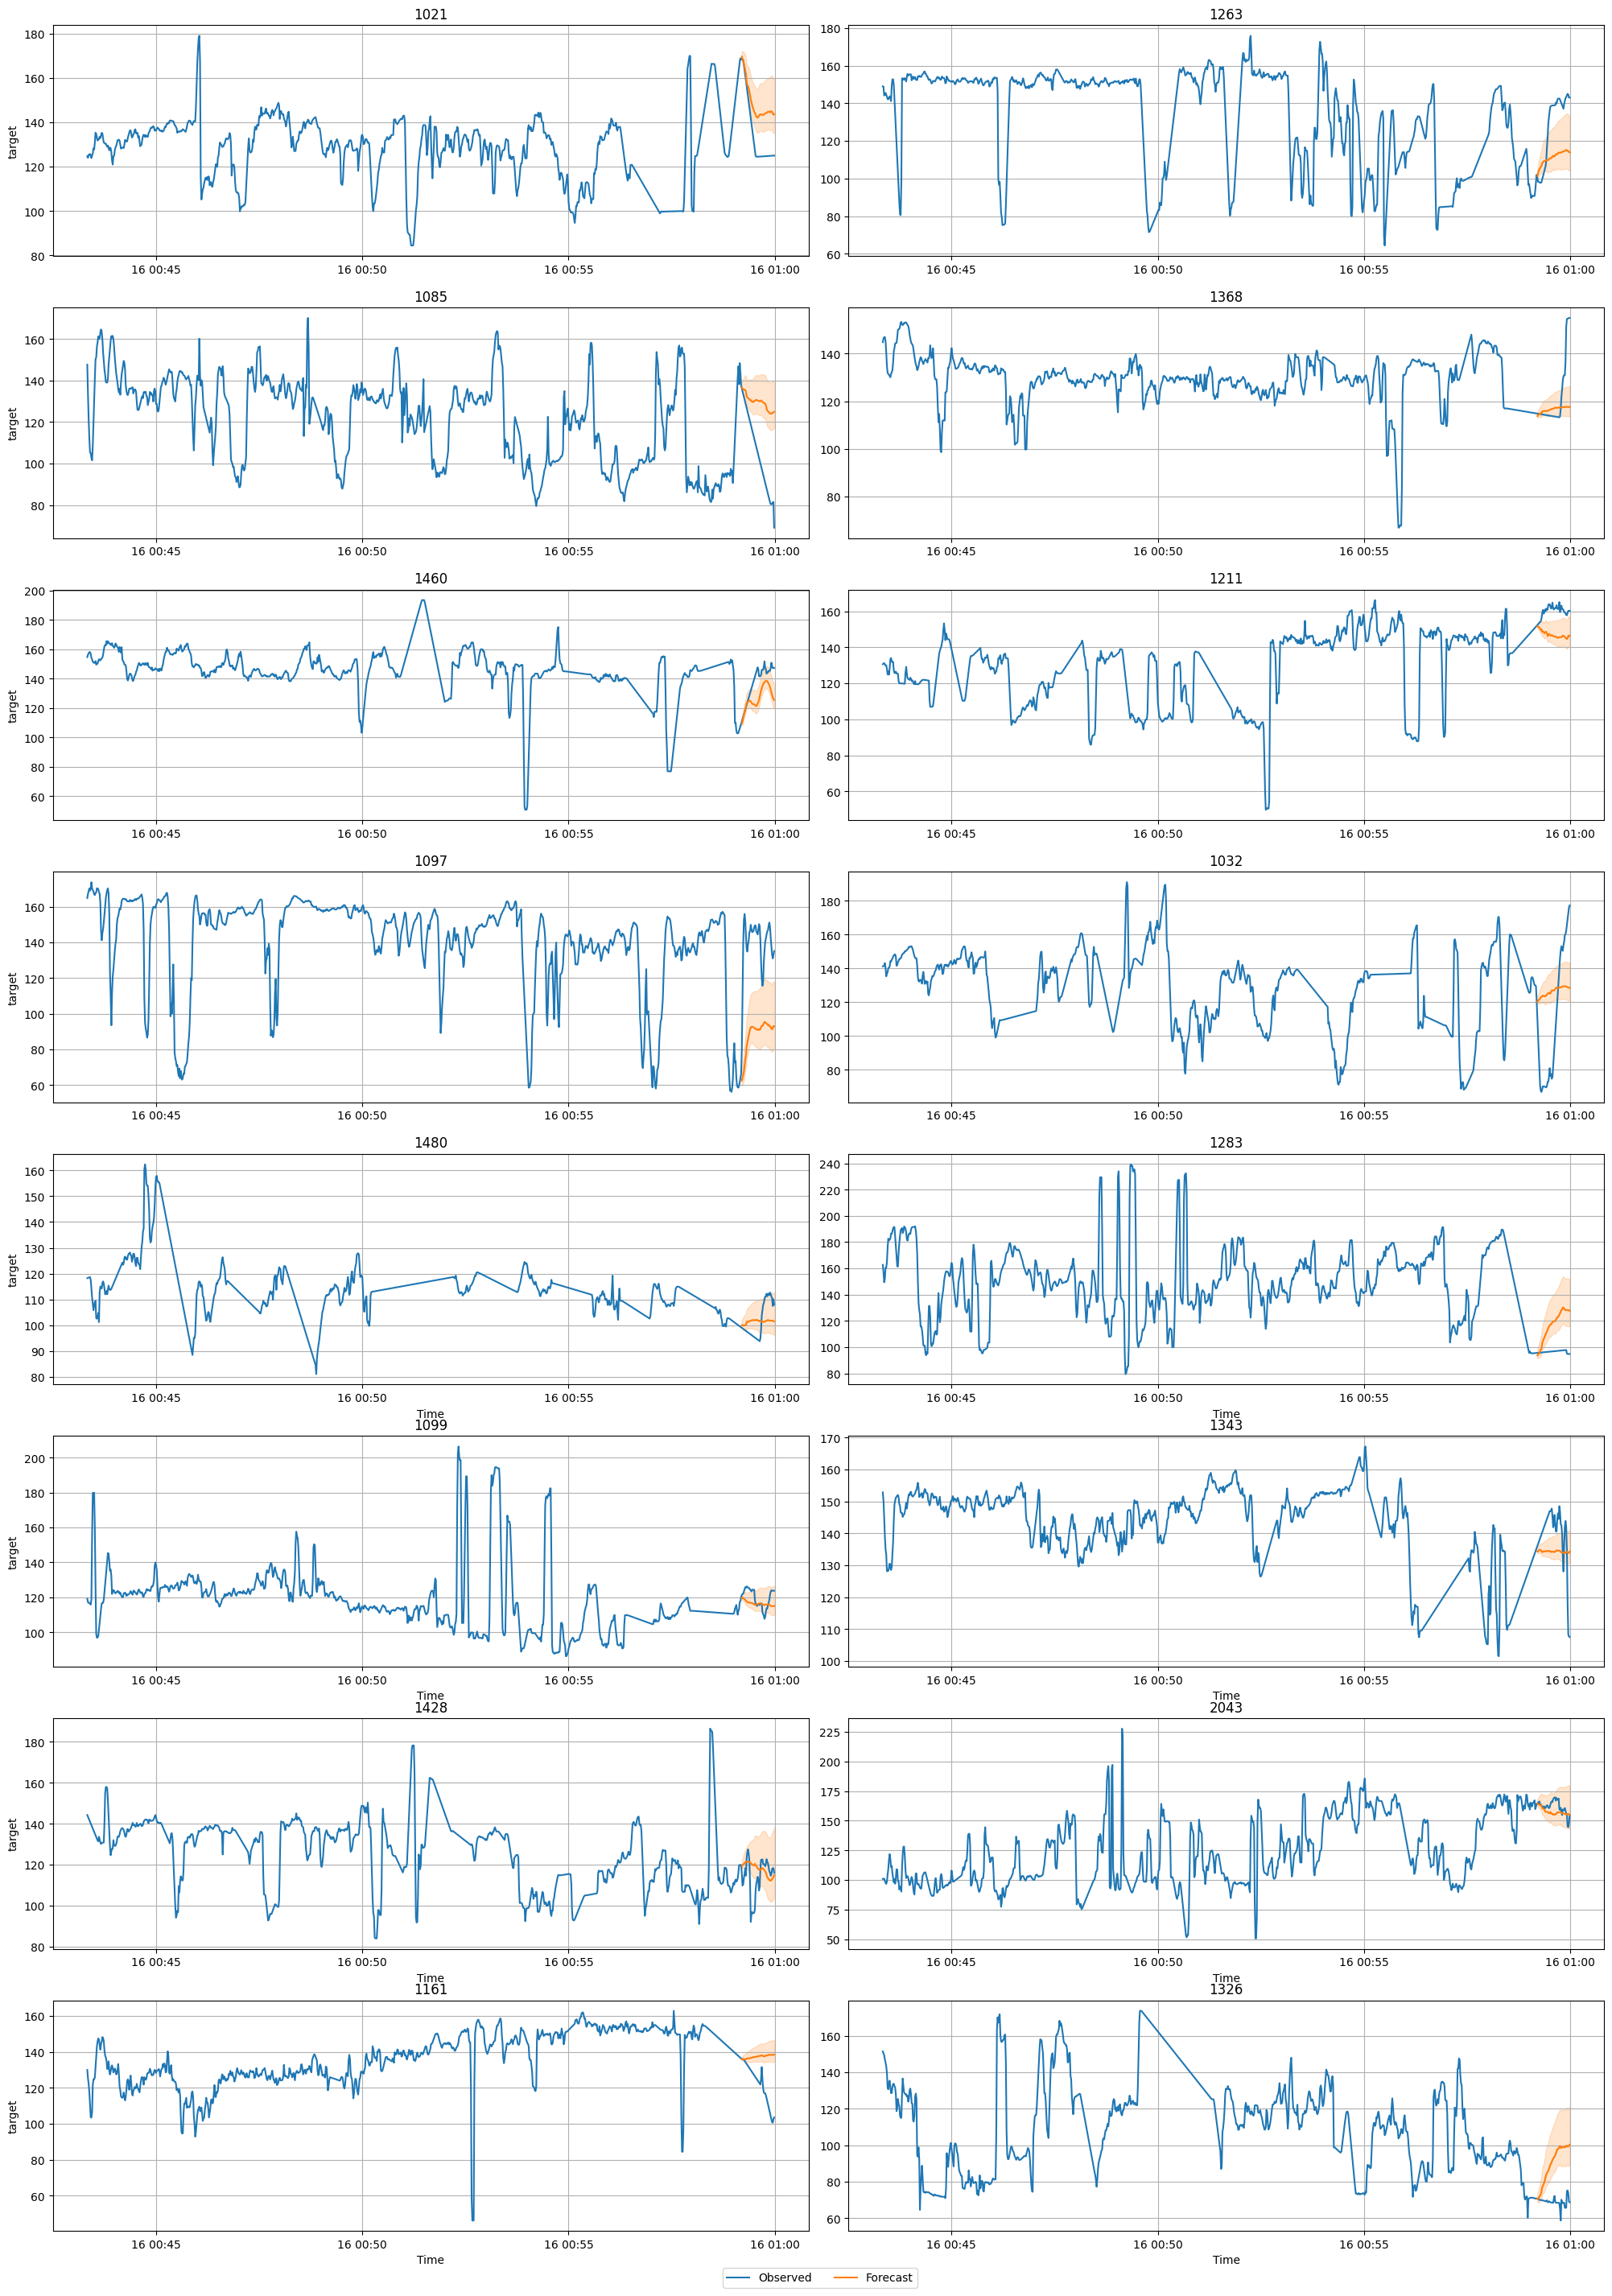

In [ ]:
predictor_zeroshot.plot(test_data, predictions, quantile_levels=[0.4, 0.7], max_history_length=1000, max_num_item_ids=16);

#### fine tune

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=600,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20250316_081639'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.44 GB / 12.67 GB (58.7%)
Disk Space Avail:   64.32 GB / 107.72 GB (59.7%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0

In [ ]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.104278,-0.102444,36.702085,36.234755,449.854294,2
1,ChronosZeroShot[bolt_small],-0.106414,-0.104620,38.544235,46.717248,0.370986,1
